<a href="https://colab.research.google.com/github/PedroAdair/PronosticoVentas/blob/main/Clustering_series_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pronostico de ventas optimizado para productos perecederos
## Andrea Garcia, Daniel Gomez, Adair Gallegos
### Centro de Investigación en Matemáticas AC  Unidad Monterrey

In [ ]:
#@title "calmap" permite generar mapas similares a los de github
!pip install calmap

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
#ojos que no ven...
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
import calendar
from datetime import datetime, timedelta
import calmap

In [3]:
data = "/content/drive/MyDrive/Consultoria/data_ventas.xlsx"

In [5]:
def ventas_calendario(nombre_archivo):
    # leer el archivo de excel en un DataFrame de pandas
    df = pd.read_excel(nombre_archivo)
    
    # convertir la columna FECHA en un objeto datetime
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    
    # agrupar por FECHA y sumar las unidades vendidas
    resumen = df.groupby('FECHA')['UNI'].sum().reset_index()
    
    # filtrar meses sin ventas
    resumen = resumen.loc[resumen['UNI'] != 0]
    
    # crear el objeto calmap
    calmap.calendarplot(resumen.set_index('FECHA')['UNI'], 
                        monthticks=3, daylabels='LMMJVSD',
                        cmap='YlGnBu', fillcolor='grey', linewidth=0.05,
                        fig_kws=dict(figsize=(20,10)))
    plt.title('Ventas por día y mes')
    plt.show()

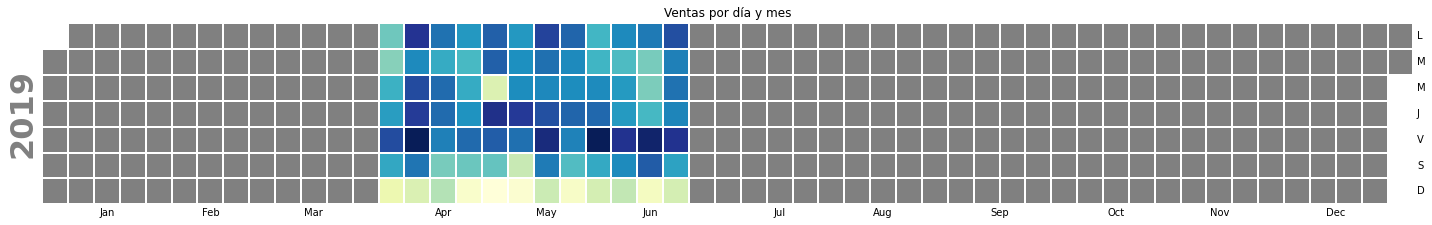

In [6]:
ventas_calendario(data)

En un primer analisis de resultados, el día de la semana que mayores ventas se registran los dias viernes, mientras que por el contrario las menores ventas se tienen los domingos.

Ahora, trataremos de hacer algunos analisis preeliminares 

In [7]:
df_ventas = pd.read_excel("/content/drive/MyDrive/Consultoria/data_ventas.xlsx")
df_catalogo = pd.read_excel("/content/drive/MyDrive/Consultoria/Catalogo.xlsx")

"Unimos" las dos bases de datos en base al Arriculo = SKU 

In [9]:
df = pd.merge(df_ventas, df_catalogo[["Articulo", "Precio", "Costo"]], left_on="SKU", right_on="Articulo", how="left")

Creamos las columnas de "Ventas" y "Ganancias"

In [10]:
df["Ventas"] = df["UNI"] * df["Precio"]
df["Ganancia"] = df["UNI"] * (df["Precio"] - df["Costo"])

Ahora generamos un nuevo df que contiene las ventas registradas por cada tienda de forma diaria. Los NA se sustituyen por 0
* ¿por que hay NA? 
* ¿Acaso corresponde a tiendas que se abrieron despues de la fecha de estudio de caso?
* ¿es posible hacer una clasificiación de series de tiempo?

In [11]:
ventas_tiendas = pd.pivot_table(df, values='Ventas', index=['LOC'], columns=[ 'FECHA'], aggfunc=sum)
ventas_tiendas = ventas_tiendas.fillna(0)
ventas_tiendas

FECHA,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,...,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23
LOC,,,,,,,,,,,,,,,,,,,,,
LOC_001,46.16,90.88,29.32,159.16,138.83,172.10,36.16,95.14,326.55,215.58,...,29.58,267.37,162.60,85.02,139.91,29.58,77.30,239.68,273.28,0.00
LOC_002,85.70,29.32,216.40,206.09,121.11,190.61,77.01,135.94,147.06,137.06,...,212.11,169.69,127.34,100.15,153.85,86.13,215.90,122.90,212.93,317.33
LOC_003,133.84,89.10,130.00,159.26,183.64,72.54,76.29,128.95,212.92,138.65,...,255.22,296.31,83.29,155.98,112.88,350.83,129.55,170.04,129.66,219.43
LOC_004,126.47,108.52,80.13,88.93,114.41,63.02,74.89,123.75,125.25,76.21,...,105.06,100.14,92.84,48.98,88.69,31.08,46.16,15.54,70.79,109.23
LOC_005,209.72,229.51,145.92,424.95,214.81,196.98,213.82,130.20,170.78,451.38,...,257.91,259.80,100.61,323.25,74.20,261.81,244.26,216.68,0.00,102.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC_414,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,58.64,141.62,51.17,27.23,54.46,46.66,0.00,83.71,52.93,20.49
LOC_415,0.00,0.00,56.55,0.00,23.35,62.86,18.08,25.67,0.00,29.32,...,29.59,0.00,23.35,111.84,27.23,58.98,7.77,37.09,0.00,0.00
LOC_416,92.98,20.49,79.65,40.98,94.54,29.32,29.32,33.62,114.67,56.12,...,0.00,111.65,25.67,88.23,145.34,55.49,92.60,78.75,202.00,102.90


In [25]:
import matplotlib.pyplot as plt
def ventas_tienda(LOC_num):
  # Seleccionar la primera fila del dataframe
  ventas_primera_tienda = ventas_tiendas.iloc[LOC_num-1]

  # Hacer el plot de la serie de tiempo
  ventas_primera_tienda.plot(figsize=(10, 6))
  plt.title(f'Ventas de la tienda')
  plt.xlabel('Fecha')
  plt.ylabel('Ventas')
  plt.show()

Al parecer existen tiendas nuevas

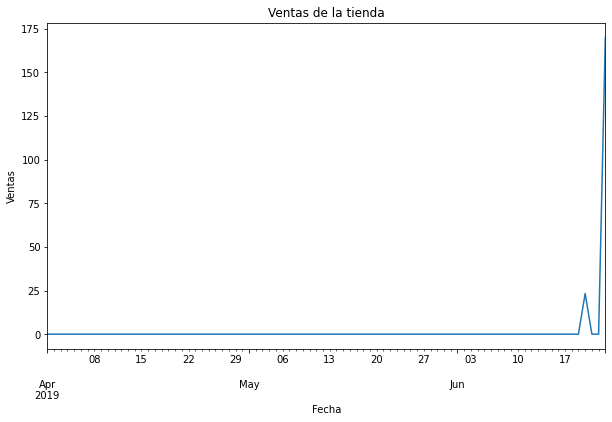

In [26]:
ventas_tienda(417)

y tiendas que ya estan consolidadas

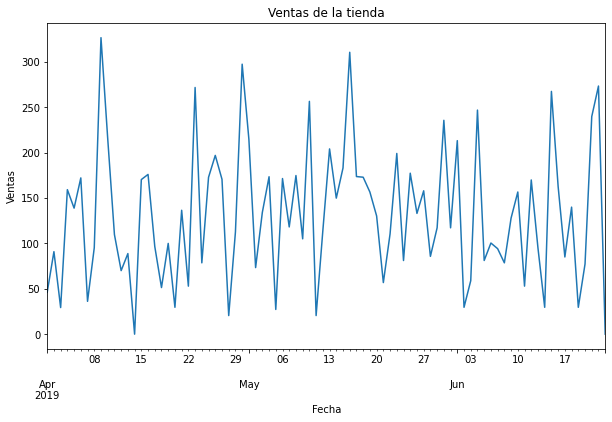

In [27]:
ventas_tienda(1)

In [30]:
ventas_tiendas

FECHA,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23
LOC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LOC_001,46.16,90.88,29.32,159.16,138.83,172.10,36.16,95.14,326.55,215.58,109.72,70.00,88.75,0.00,170.27,175.94,96.65,51.34,99.95,29.59,136.47,52.89,271.68,78.56,172.80,196.89,170.56,20.49,112.64,297.34,214.61,73.33,134.07,173.38,27.23,171.41,118.11,174.70,105.00,256.39,20.49,113.96,204.03,149.83,183.04,310.46,173.59,172.87,156.50,130.19,56.82,110.46,199.02,81.11,177.29,133.02,157.90,85.70,117.18,235.53,117.13,213.14,29.59,58.90,246.79,81.15,100.38,94.16,78.57,127.84,156.58,52.90,169.84,94.80,29.58,267.37,162.60,85.02,139.91,29.58,77.30,239.68,273.28,0.00
LOC_002,85.70,29.32,216.40,206.09,121.11,190.61,77.01,135.94,147.06,137.06,29.58,174.93,50.07,266.03,76.61,131.02,184.77,132.27,62.86,69.42,340.37,29.58,193.02,161.05,246.84,37.09,233.04,70.63,56.81,237.51,0.00,234.32,92.45,164.17,0.00,109.45,301.14,145.56,115.99,201.00,84.04,84.04,76.61,88.76,199.02,36.03,100.22,86.13,29.58,92.44,47.67,90.88,227.81,56.55,228.60,29.58,25.67,223.39,115.98,62.86,232.78,131.47,79.40,84.57,142.98,113.63,133.81,157.37,456.25,56.82,66.95,62.86,59.16,117.67,212.11,169.69,127.34,100.15,153.85,86.13,215.90,122.90,212.93,317.33
LOC_003,133.84,89.10,130.00,159.26,183.64,72.54,76.29,128.95,212.92,138.65,272.44,0.00,338.06,176.16,257.87,192.37,236.59,177.42,194.37,191.09,61.30,92.77,278.37,295.06,80.14,157.23,175.29,82.25,481.58,288.50,390.37,182.86,150.91,204.85,108.13,102.58,238.93,213.16,180.50,120.04,215.25,52.94,170.96,333.27,103.52,176.66,191.95,202.18,253.32,190.86,111.28,344.90,204.57,160.74,106.61,131.51,152.20,96.30,50.58,182.13,189.61,134.72,192.22,100.16,238.84,177.33,148.84,59.17,209.64,128.61,137.78,187.53,208.72,82.49,255.22,296.31,83.29,155.98,112.88,350.83,129.55,170.04,129.66,219.43
LOC_004,126.47,108.52,80.13,88.93,114.41,63.02,74.89,123.75,125.25,76.21,200.17,0.00,80.76,41.39,58.90,74.95,7.77,55.25,29.58,23.31,0.00,0.00,109.90,15.54,199.27,55.25,121.27,47.66,76.99,29.58,139.30,0.00,29.32,31.08,59.16,113.56,165.13,74.90,76.20,86.13,79.65,7.77,56.55,75.74,116.02,70.00,73.38,77.77,141.63,25.67,139.29,72.29,77.77,281.46,186.54,25.67,132.67,111.80,121.11,90.24,52.90,109.71,93.82,74.71,150.44,101.88,127.60,163.39,103.97,43.80,106.82,0.00,95.66,7.77,105.06,100.14,92.84,48.98,88.69,31.08,46.16,15.54,70.79,109.23
LOC_005,209.72,229.51,145.92,424.95,214.81,196.98,213.82,130.20,170.78,451.38,172.94,340.51,293.29,190.56,446.24,47.72,141.92,74.95,275.25,97.16,123.47,301.28,208.54,175.48,143.52,158.68,248.34,37.35,132.23,146.68,80.94,298.02,254.00,81.69,65.74,282.64,169.91,311.63,162.62,56.55,238.13,77.81,275.21,319.66,295.30,306.07,195.36,280.61,56.81,252.23,355.19,94.29,210.28,225.47,380.40,170.78,238.40,121.65,198.77,432.68,265.04,349.93,54.46,267.03,116.69,328.73,0.00,197.23,267.23,247.05,120.85,280.32,172.13,297.22,257.91,259.80,100.61,323.25,74.20,261.81,244.26,216.68,0.00,102.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [42]:
columnas = ventas_tiendas.columns.values[1:]
data = pd.pivot_table(ventas_tiendas, columns='LOC', values=columnas).reset_index()

##Analisis sobre las ventas totales

In [86]:
data.head()

LOC,FECHA,LOC_001,LOC_002,LOC_003,LOC_004,LOC_005,LOC_006,LOC_007,LOC_008,LOC_009,LOC_010,LOC_011,LOC_012,LOC_013,LOC_014,LOC_015,LOC_016,LOC_017,LOC_018,LOC_019,LOC_020,LOC_021,LOC_022,LOC_023,LOC_024,LOC_025,LOC_026,LOC_027,LOC_028,LOC_029,LOC_030,LOC_031,LOC_032,LOC_033,LOC_034,LOC_035,LOC_036,LOC_037,LOC_038,LOC_039,LOC_040,LOC_041,LOC_042,LOC_043,LOC_044,LOC_045,LOC_046,LOC_047,LOC_048,LOC_049,LOC_050,LOC_051,LOC_052,LOC_053,LOC_054,LOC_055,LOC_056,LOC_057,LOC_058,LOC_059,LOC_060,LOC_061,LOC_062,LOC_063,LOC_064,LOC_065,LOC_066,LOC_067,LOC_068,LOC_069,LOC_070,LOC_071,LOC_072,LOC_073,LOC_074,LOC_075,LOC_076,LOC_077,LOC_078,LOC_079,LOC_080,LOC_081,LOC_082,LOC_083,LOC_084,LOC_085,LOC_086,LOC_087,LOC_088,LOC_089,LOC_090,LOC_091,LOC_092,LOC_093,LOC_094,LOC_095,LOC_096,LOC_097,LOC_098,LOC_099,LOC_100,LOC_101,LOC_102,LOC_103,LOC_104,LOC_105,LOC_106,LOC_107,LOC_108,LOC_109,LOC_110,LOC_111,LOC_112,LOC_113,LOC_114,LOC_115,LOC_116,LOC_117,LOC_118,LOC_119,LOC_120,LOC_121,LOC_122,LOC_123,LOC_124,LOC_125,LOC_126,LOC_127,LOC_128,LOC_129,LOC_130,LOC_131,LOC_132,LOC_133,LOC_134,LOC_135,LOC_136,LOC_137,LOC_138,LOC_139,LOC_140,LOC_141,LOC_142,LOC_143,LOC_144,LOC_145,LOC_146,LOC_147,LOC_148,LOC_149,LOC_150,LOC_151,LOC_152,LOC_153,LOC_154,LOC_155,LOC_156,LOC_157,LOC_158,LOC_159,LOC_160,LOC_161,LOC_162,LOC_163,LOC_164,LOC_165,LOC_166,LOC_167,LOC_168,LOC_169,LOC_170,LOC_171,LOC_172,LOC_173,LOC_174,LOC_175,LOC_176,LOC_177,LOC_178,LOC_179,LOC_180,LOC_181,LOC_182,LOC_183,LOC_184,LOC_185,LOC_186,LOC_187,LOC_188,LOC_189,LOC_190,LOC_191,LOC_192,LOC_193,LOC_194,LOC_195,LOC_196,LOC_197,LOC_198,LOC_199,LOC_200,LOC_201,LOC_202,LOC_203,LOC_204,LOC_205,LOC_206,LOC_207,LOC_208,LOC_209,LOC_210,LOC_211,LOC_212,LOC_213,LOC_214,LOC_215,LOC_216,LOC_217,LOC_218,LOC_219,LOC_220,LOC_221,LOC_222,LOC_223,LOC_224,LOC_225,LOC_226,LOC_227,LOC_228,LOC_229,LOC_230,LOC_231,LOC_232,LOC_233,LOC_234,LOC_235,LOC_236,LOC_237,LOC_238,LOC_239,LOC_240,LOC_241,LOC_242,LOC_243,LOC_244,LOC_245,LOC_246,LOC_247,LOC_248,LOC_249,LOC_250,LOC_251,LOC_252,LOC_253,LOC_254,LOC_255,LOC_256,LOC_257,LOC_258,LOC_259,LOC_260,LOC_261,LOC_262,LOC_263,LOC_264,LOC_265,LOC_266,LOC_267,LOC_268,LOC_269,LOC_270,LOC_271,LOC_272,LOC_273,LOC_274,LOC_275,LOC_276,LOC_277,LOC_278,LOC_279,LOC_280,LOC_281,LOC_282,LOC_283,LOC_284,LOC_285,LOC_286,LOC_287,LOC_288,LOC_289,LOC_290,LOC_291,LOC_292,LOC_293,LOC_294,LOC_295,LOC_296,LOC_297,LOC_298,LOC_299,LOC_300,LOC_301,LOC_302,LOC_303,LOC_304,LOC_305,LOC_306,LOC_307,LOC_308,LOC_309,LOC_310,LOC_311,LOC_312,LOC_313,LOC_314,LOC_315,LOC_316,LOC_317,LOC_318,LOC_319,LOC_320,LOC_321,LOC_322,LOC_323,LOC_324,LOC_325,LOC_326,LOC_327,LOC_328,LOC_329,LOC_330,LOC_331,LOC_332,LOC_333,LOC_334,LOC_335,LOC_336,LOC_337,LOC_338,LOC_339,LOC_340,LOC_341,LOC_342,LOC_343,LOC_344,LOC_345,LOC_346,LOC_347,LOC_348,LOC_349,LOC_350,LOC_351,LOC_352,LOC_353,LOC_354,LOC_355,LOC_356,LOC_357,LOC_358,LOC_359,LOC_360,LOC_361,LOC_362,LOC_363,LOC_364,LOC_365,LOC_366,LOC_367,LOC_368,LOC_369,LOC_370,LOC_371,LOC_372,LOC_373,LOC_374,LOC_375,LOC_376,LOC_377,LOC_378,LOC_379,LOC_380,LOC_381,LOC_382,LOC_383,LOC_384,LOC_385,LOC_386,LOC_387,LOC_388,LOC_389,LOC_390,LOC_391,LOC_392,LOC_393,LOC_394,LOC_395,LOC_396,LOC_397,LOC_398,LOC_399,LOC_400,LOC_401,LOC_402,LOC_403,LOC_404,LOC_405,LOC_406,LOC_407,LOC_408,LOC_409,LOC_410,LOC_411,LOC_412,LOC_413,LOC_414,LOC_415,LOC_416,LOC_417,LOC_420,day
0,2019-04-02,90.88,29.32,89.10,108.52,229.51,52.93,229.32,65.22,29.32,66.65,29.32,108.19,143.98,56.82,143.52,104.03,386.72,490.55,137.73,73.39,59.16,86.14,86.39,204.84,448.93,80.76,77.30,117.21,94.53,168.62,170.52,195.83,317.70,471.41,189.68,229.05,188.43,263.45,161.62,94.38,410.62,160.54,50.58,90.89,0.00,149.68,59.16,115.24,273.14,59.17,109.45,192.81,164.52,165.13,59.16,203.37,124.19,133.56,133.86,277.13,0.00,260.04,58.90,25.67,18.08,29.59,247.24,50.08,205.43,218.68,51.34,128.06,131.27,377.50,151.19,56.55,167.35,191.71,191.62,167.96,29.58,73.42,329.60,322.59,40.98,122.36,76.21,346.81,236.50,29.32,35.63,29.32,120.47,124.32,82.51,0.00,

In [87]:
data.FECHA = pd.to_datetime(data.FECHA)
data['day'] = data['FECHA'].apply(lambda x:x.weekday())
x_call = data.columns[1:-1]

###1. Segmentación

In [90]:
data_fix = pd.DataFrame({'LOC':range(1,419,1),'total':np.sum(data[x_call]).values})

data_fix['PromedioDiario']=data[x_call].mean().values
data_fix['% Lunes']=data[data['day']==0][x_call].sum().values/data_fix['total']*100
data_fix['% Martes']=data[data['day']==1][x_call].sum().values/data_fix['total']*100
data_fix['% Miercoles']=data[data['day']==2][x_call].sum().values/data_fix['total']*100
data_fix['% Jueves']=data[data['day']==3][x_call].sum().values/data_fix['total']*100
data_fix['% Viernes']=data[data['day']==4][x_call].sum().values/data_fix['total']*100
data_fix['% Sabado']=data[data['day']==5][x_call].sum().values/data_fix['total']*100
data_fix['% Domingo']=data[data['day']==6][x_call].sum().values/data_fix['total']*100
data_fix['% SemanaLaboral']=data[(data['day']!=5)&(data['day']!=6)][x_call].sum().values/data_fix['total']*100
data_fix['% FinSemana']=data[(data['day']==5)|(data['day']==6)][x_call].sum().values/data_fix['total']*100

In [91]:
data_fix=data_fix.fillna(0)
data_fix.head()

,LOC,total,PromedioDiario,% Lunes,% Martes,% Miercoles,% Jueves,% Viernes,% Sabado,% Domingo,% SemanaLaboral,% FinSemana
0,1,11009.56,132.645301,12.670534,18.279114,13.630608,15.339759,14.817849,16.689041,8.573095,74.737864,25.262136
1,2,11008.09,132.627590,7.765016,15.975342,13.713914,15.980701,14.274683,18.862673,13.427670,67.709657,32.290343
2,3,14643.12,176.423133,13.464958,16.255347,18.026964,13.500265,12.517278,15.544501,10.690686,73.764812,26.235188
3,4,6761.43,81.463012,12.106906,17.441429,13.782440,15.371896,14.884721,15.499828,10.912780,73.587392,26.412608
4,5,17227.86,207.564578,16.076054,13.007129,15.430239,16.064154,15.425537,15.634908,8.361979,76.003114,23.996886


#### Standardization 

In [108]:
from sklearn.preprocessing import StandardScaler
x_calls = data_fix.columns[1:]
scaller = StandardScaler()
matrix = pd.DataFrame(scaller.fit_transform(data_fix[x_calls]),columns=x_calls)
matrix['LOC'] = data_fix['LOC']
matrix.head()

,total,PromedioDiario,% Lunes,% Martes,% Miercoles,% Jueves,% Viernes,% Sabado,% Domingo,% SemanaLaboral,% FinSemana,LOC
0,0.104503,0.104503,-0.281313,1.093740,-0.155144,0.003227,-0.384144,0.458611,-0.525068,0.136638,-0.136638,1
1,0.104361,0.104361,-1.610969,0.464327,-0.129964,0.200058,-0.537032,0.942067,0.281610,-0.738035,0.738035,2
2,0.453564,0.453564,-0.065982,0.540827,1.173699,-0.561675,-1.031699,0.204044,-0.173190,0.015540,-0.015540,3
3,-0.303598,-0.303598,-0.434086,0.864876,-0.109251,0.013096,-0.365321,0.194108,-0.136285,-0.006540,0.006540,4
4,0.701870,0.701870,0.641763,-0.346618,0.388813,0.225686,-0.213095,0.224152,-0.560148,0.294101,-0.294101,5


#### Correlation

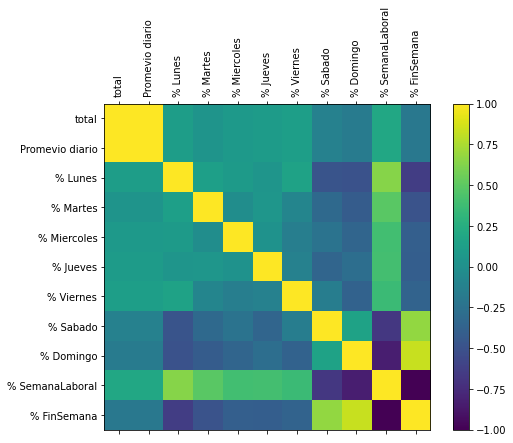

In [78]:
corr = matrix[x_calls].corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax=ax.matshow(corr,vmin=-1,vmax=1)
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(rotation=90)
plt.colorbar(cax)

#### Determinar el número de cluster para la segmentación de tiendas

In [106]:
def plot_BIC(matrix,x_calls,K):
    from sklearn import mixture
    BIC=[]
    for k in K:
        model= mixture.GaussianMixture(n_components=k,
                                       init_params='k-means++')
        model.fit(matrix[x_calls])
        BIC.append(model.bic(matrix[x_calls]))
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(K,BIC,'-cx')
    plt.ylabel("BIC score")
    plt.xlabel("k")
    plt.title("BIC scoring for K-means cell's behaviour")
    return(BIC)

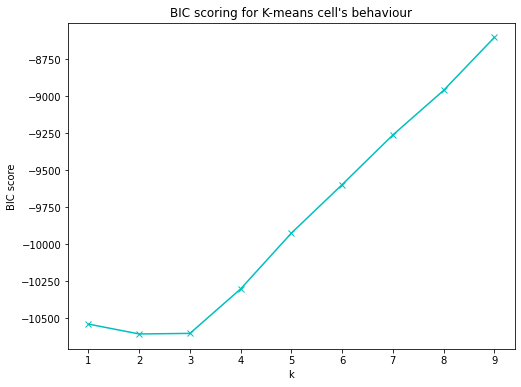

In [107]:
K = range(1,10)
BIC = plot_BIC(matrix,x_calls,K)

Hay evidencia de solo 3 grupos, para replicabilidad la semilla es 1

In [109]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
cluster = KMeans(n_clusters=3,random_state=1)
matrix['cluster'] = cluster.fit_predict(matrix[x_calls])
print(matrix.cluster.value_counts())

0    229
2    134
1     55
Name: cluster, dtype: int64


Text(0.5, 1.0, 'Cluster of Data')

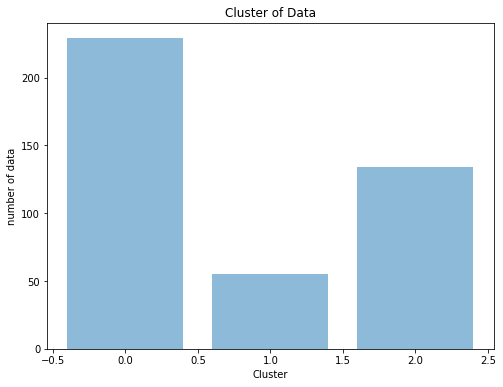

In [110]:
d=pd.DataFrame(matrix.cluster.value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(d.index,d['cluster'],align='center',alpha=0.5)
plt.xlabel('Cluster')
plt.ylabel('number of data')
plt.title('Cluster of Data')

In [111]:
from sklearn.metrics.pairwise import euclidean_distances
distance = euclidean_distances(cluster.cluster_centers_, cluster.cluster_centers_)
print(distance)

[[0.         3.26014605 2.70798776]
 [3.26014605 0.         5.5239227 ]
 [2.70798776 5.5239227  0.        ]]


In [112]:
# Reduction dimention of the data using PCA
pca = PCA(n_components=3)
matrix['x'] = pca.fit_transform(matrix[x_calls])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_calls])[:,1]
matrix['z'] = pca.fit_transform(matrix[x_calls])[:,2]

# Getting the center of each cluster for plotting
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y', 'z'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
print(cluster_centers)

          x         y         z  cluster
0 -0.437699 -0.439720  0.124174        0
1 -3.351339  0.932430 -0.344331        1
2  2.123558  0.368748 -0.070878        2


Text(0.5, 1.0, 'Data Segmentation')

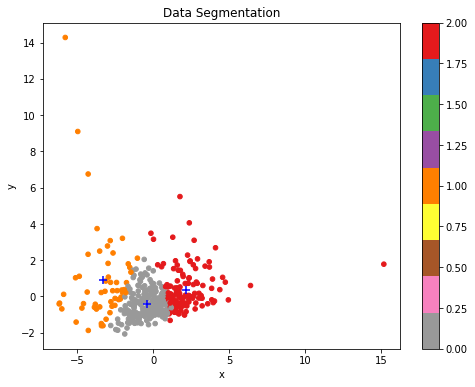

In [113]:
# Plotting for 2-dimention
fig, ax = plt.subplots(figsize=(8, 6))
scatter=ax.scatter(matrix['x'],matrix['y'],c=matrix['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],s=70,c='blue',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)
plt.title('Data Segmentation')

Text(0.5, 0.92, 'Data Segmentation')

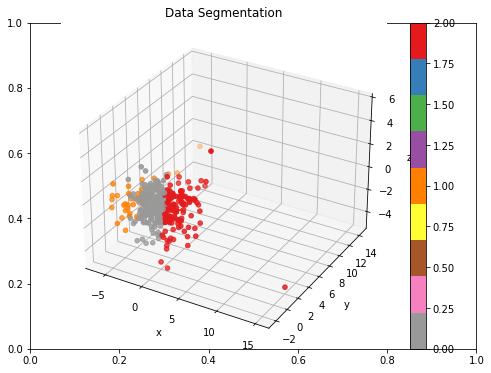

In [114]:
# Plotting for 3-Dimention
fig, ax = plt.subplots(figsize=(8, 6))
ax=fig.add_subplot(111, projection='3d')
scatter=ax.scatter(matrix['x'],matrix['y'],matrix['z'],c=matrix['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],cluster_centers['z'],s=70,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.colorbar(scatter)
plt.title('Data Segmentation')

In [116]:
data_fix['cluster']=matrix['cluster']
data_fix[data_fix.columns[1:]].groupby(['cluster']).agg([np.mean])

,total,PromedioDiario,% Lunes,% Martes,% Miercoles,% Jueves,% Viernes,% Sabado,% Domingo,% SemanaLaboral,% FinSemana
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,
0,7481.155371,90.134402,14.510948,14.785947,14.140757,15.543495,16.702113,13.716606,10.600136,75.683259,24.316741
1,22463.287455,270.642018,17.098104,16.674847,16.520679,17.628009,17.544141,9.169801,5.364420,85.465779,14.534221
2,8944.937537,107.770332,10.945544,12.419353,13.173687,14.019600,14.735933,18.423075,16.282807,65.294118,34.705882


In [119]:
c0 = list(data_fix[data_fix.cluster==0]['LOC'])
c1 = list(data_fix[data_fix.cluster==1]['LOC'])
c2 = list(data_fix[data_fix.cluster==2]['LOC'])

### 2. Forecasting Using Fbprophet¶


En esta etapa de este kernel, tratamos de pronosticar para un mes por delante   usando una biblioteca simple y muy agradable desarrollada por Facebook llamada Fbprophet. La teoría con una muy buena descripción del enfoque matemático/estadístico detrás de la biblioteca se puede ver en https://facebook.github.io/prophet/.

In [121]:
data_cluster=data_fix[['LOC','cluster']]
data_forc=pd.DataFrame({'ds':pd.to_datetime(data['FECHA'])})

In [129]:
for k in range(len(cluster_centers)):
    data_clus=data_cluster[data_cluster['cluster']==k]
    del data_clus['cluster']
    s1="cluster "+str(k)
    data_forc[s1]=0
    for i in list(data_clus.iloc[:,0]):
        s2="LOC_"+ str(i).rjust(3, '0')
        data_forc[s1]+=data[s2]
data_forc=data_forc.fillna(0)

KeyError: ignored

idea: agregar la tienda 418 y 419 con solo 0´s